In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

df = pd.read_csv("Australiafertility.csv")

ages = df["age"].to_numpy()

# keep only the year columns
year_cols = [c for c in df.columns if c != "age"]
years = np.array([int(c) for c in year_cols])

# matrix: rows = ages, cols = years  (what we want)
rates = df[year_cols].to_numpy()

smoothed = np.zeros_like(rates)

df.head(5)

,age,1921,1922,1923,1924,1925,1926,1927,1928,1929,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,15,1.749997,1.589998,1.589998,1.709998,2.099998,2.399997,2.300000,2.399998,2.499998,...,2.633619,3.342309,3.405054,3.666621,3.111861,2.857143,2.931257,2.701424,2.384142,2.148757
1,16,6.843768,6.595236,6.854068,7.474161,8.094822,8.693913,8.319840,8.995146,9.295174,...,6.684994,6.972223,7.953156,7.593783,7.028858,6.635372,6.614941,5.783921,4.903513,4.476864
2,17,18.277846,18.981300,19.651100,21.684603,22.278423,22.481338,24.406602,24.574205,25.071629,...,14.128215,13.685640,15.431949,14.626299,13.905542,13.642071,13.522309,11.571730,9.572760,8.903475
3,18,39.182681,39.482735,41.025837,42.774534,44.559839,44.210914,47.252429,47.512808,46.592520,...,23.545704,23.803101,25.659265,24.390591,23.404054,22.650467,22.716018,20.233057,17.416039,16.142488
4,19,67.528095,65.188310,66.777261,65.687389,70.048438,69.859469,70.473679,71.963729,68.011228,...,32.718113,35.600269,36.637912,35.039902,33.652595,31.672058,32.219773,30.342590,27.525540,25.523773


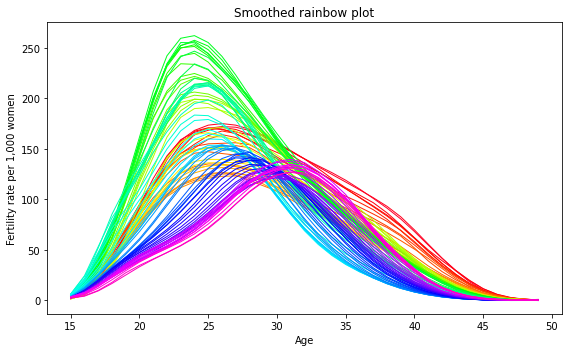

In [ ]:
# smooth each YEAR curve as a function of age
for i in range(rates.shape[1]): # Loop over each year
    # Build the spline f_i(x) that minimizes reconstruction error + smoothing penalty (Second derivative):
    spl = UnivariateSpline(ages, rates[:, i], s=5.0)  
    smoothed[:, i] = spl(ages) # Evaluate that function at all ages (y = f_i(x_j)) and store the smooth curve

# plot
cmap = plt.colormaps["gist_rainbow"]
colors = cmap(np.linspace(0, 1, len(years)))

plt.figure(figsize=(8, 5))
for i, year in enumerate(years):
    plt.plot(ages, smoothed[:, i], color=colors[i], lw=1)

plt.xlabel("Age")
plt.ylabel("Fertility rate per 1,000 women")
plt.title("Smoothed rainbow plot")
plt.tight_layout()
plt.show()

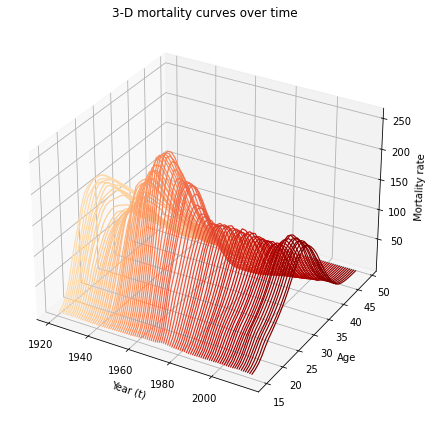

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3d projection

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

# optional nice gradient colors
cmap = plt.colormaps["OrRd"]
colors = cmap(np.linspace(0.2, 1, len(years)))

for i, year in enumerate(years):
    ax.plot(
        np.full_like(ages, year),   # time (t) axis
        ages,                       # age axis
        rates[:, i],                # mortality values
        color=colors[i],
        linewidth=1.2
    )

ax.set_xlabel("Year (t)")
ax.set_ylabel("Age")
ax.set_zlabel("Mortality rate")
ax.set_title("3-D mortality curves over time")

plt.tight_layout()
plt.show()